## NETWORK ANOMALY DETECTION

### 0 - Pre-requisites - LIBRARIES

In [1]:
! pip install scikit-learn networkx

### 2 - Understand the concept of end host profile using graphlet

The concept of an end host profile using graphlets is based on observing the transport-layer behavior of a host to construct a specialized graph structure, called a graphlet, which captures the intricate relationships between flow attributes such as IP addresses and ports. A graphlet is designed with a specific architecture consisting of columns for the source IP, protocol, destination IP, source port, destination port, and a repeated destination IP, a redundancy that is critical for observing all pairwise interactions between the most information-rich fields. The actual profile is derived by distinguishing between a raw "activity graphlet," which includes all monitored flows, and the refined "profile graphlet," which is a compressed version that retains only "significant nodes"—defined as those with an in-degree or out-degree larger than one—thereby filtering out transient or ephemeral noise. This profiling mechanism is dynamic and adaptive, employing a "delayed-accept" policy to ensure that only persistent behaviors are incorporated into the profile and an "aging" policy to remove stale patterns, ultimately creating a compact, stable, and interpretable representation of the host's dominant role in the network.

### 3 - Build (by hand) the graphlets corresponding to the following network flows

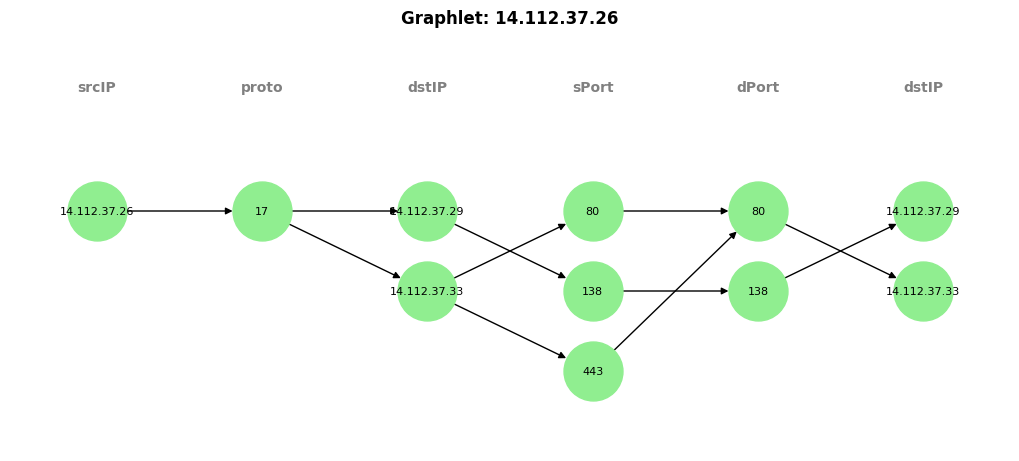

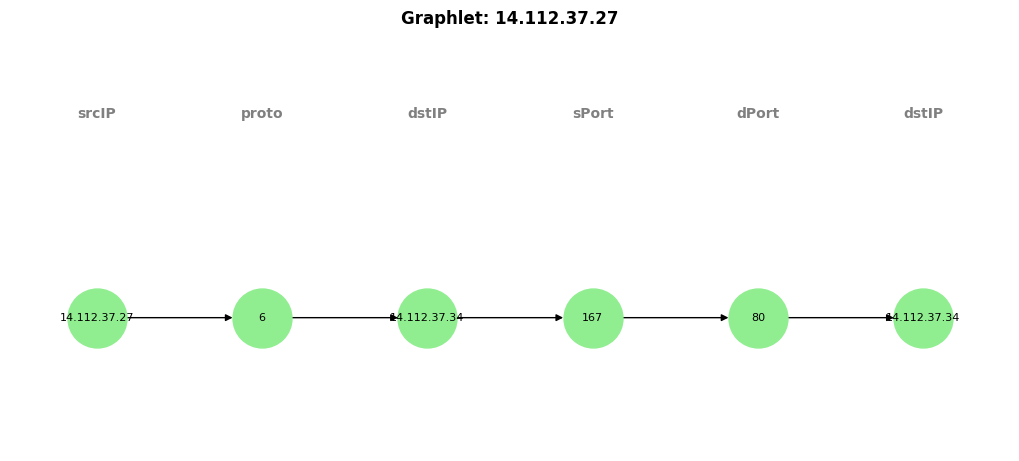

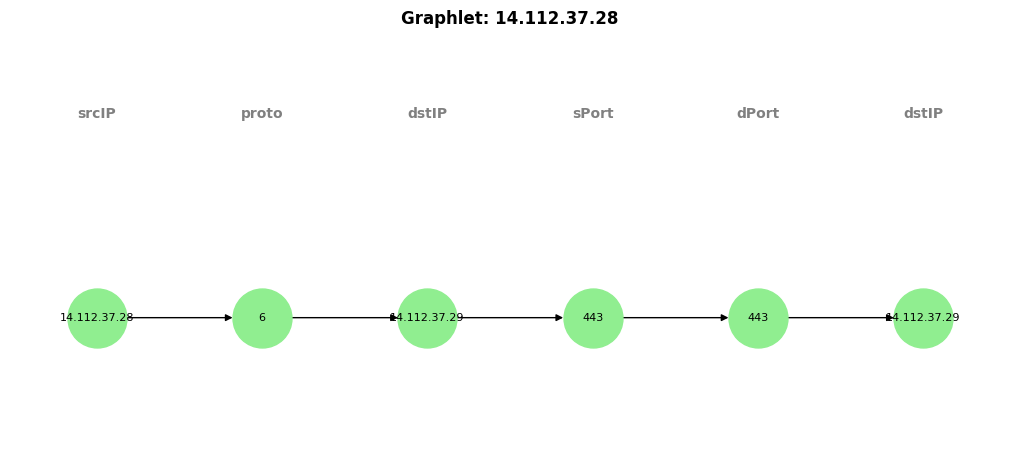

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graphlet(source_ip, flows):
    G = nx.DiGraph()
    # 6 columns: srcIP(0), proto(1), dstIP(2), sPort(3), dPort(4), dstIP(5)
    cols = ["srcIP", "proto", "dstIP", "sPort", "dPort", "dstIP"]

    for proto, dst_ip, s_port, d_port in flows:
        # Use (column_index, value) as ID to merge identical values in same column
        path = [(0, source_ip), (1, str(proto)), (2, dst_ip),
                (3, s_port), (4, d_port), (5, dst_ip)]
        for i in range(len(path) - 1):
            G.add_edge(path[i], path[i+1])

    # Position logic: X = column index, Y = incremental based on nodes in that column
    pos = {}
    col_counts = {}
    for node in sorted(G.nodes):
        col = node[0]
        col_counts[col] = col_counts.get(col, 0) + 1
        pos[node] = (col, -col_counts[col])

    plt.figure(figsize=(10, 4))
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, labels={n: n[1] for n in G.nodes},
            node_color='lightgreen', node_size=1800, font_size=8, arrows=True)

    # Titles and Column Labels
    plt.title(f"Graphlet: {source_ip}", fontweight='bold', pad=20)
    for i, name in enumerate(cols):
        plt.text(i, 0.5, name, ha='center', fontweight='bold', color='gray')

    plt.ylim(-max(col_counts.values()) - 1, 1) # Adjust space for labels
    plt.show()

# Data representing the flows from your request
data = {
    "14.112.37.26": [(17, "14.112.37.29", 138, 138), (17, "14.112.37.33", 80, 80), (17, "14.112.37.33", 443, 80)],
    "14.112.37.27": [(6, "14.112.37.34", 167, 80)],
    "14.112.37.28": [(6, "14.112.37.29", 443, 443)]
}

for src, flows in data.items():
    draw_graphlet(src, flows)

### 4 - A traffic trace with annotated flows (normal or malicious) is provided in the file annotated-trace.txt

In [3]:
import pandas as pd
from google.colab import files

# 1. Upload the file from your local machine
uploaded = files.upload()



Saving annotated-trace.csv to annotated-trace.csv


### 5 - Build all the end host graphlets corresponding to flows in annotated-trace.txt

Successfully built graphlets for 1001 unique end hosts.


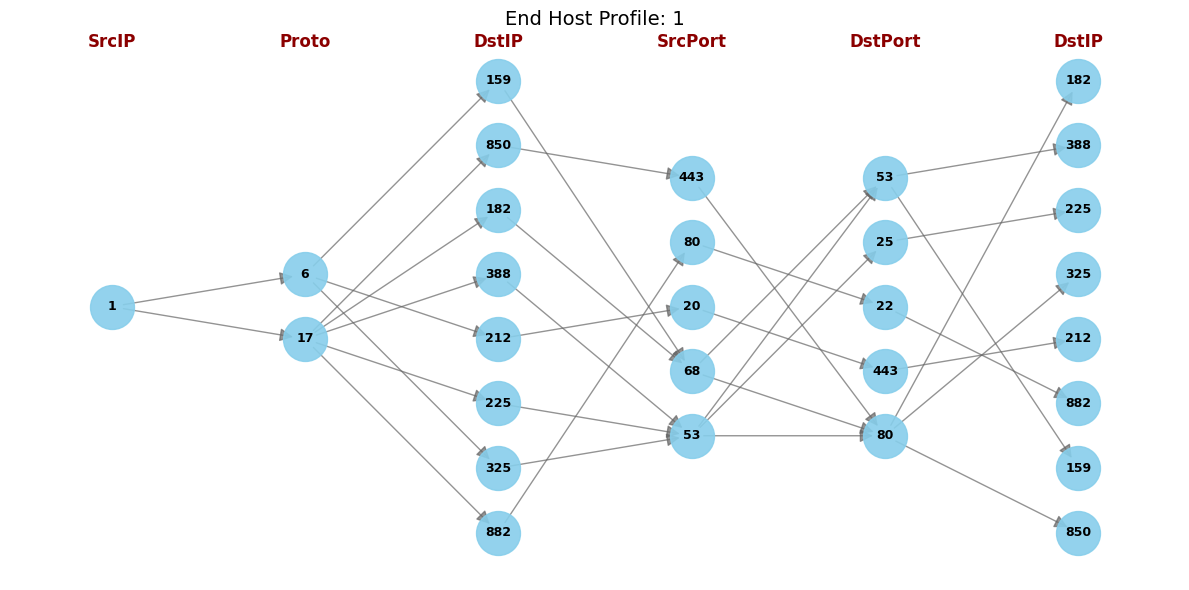

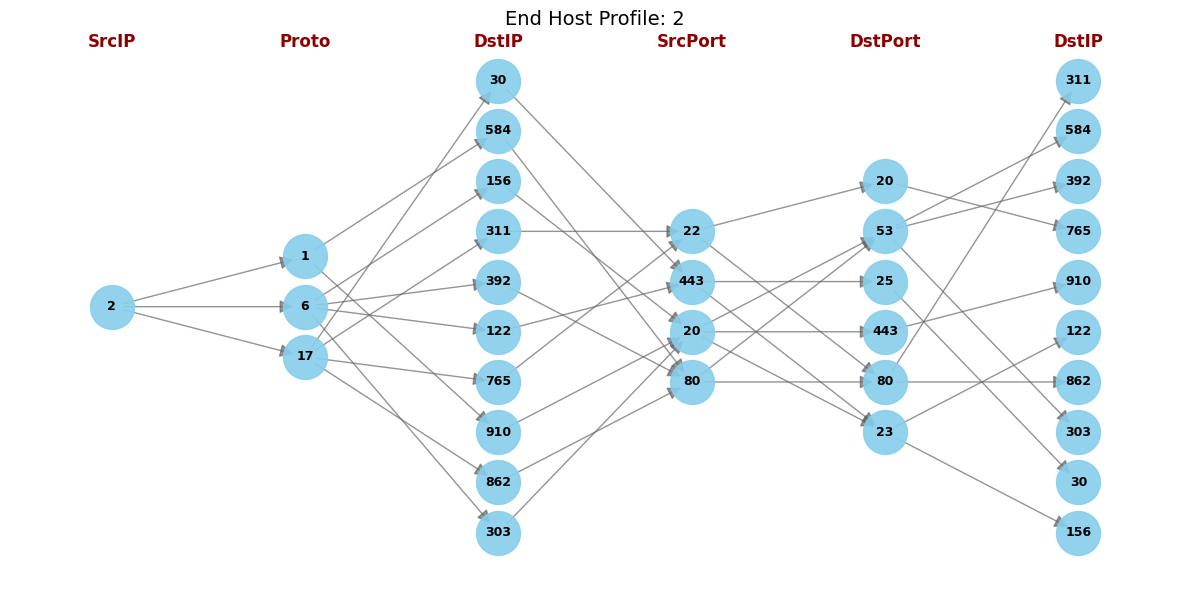

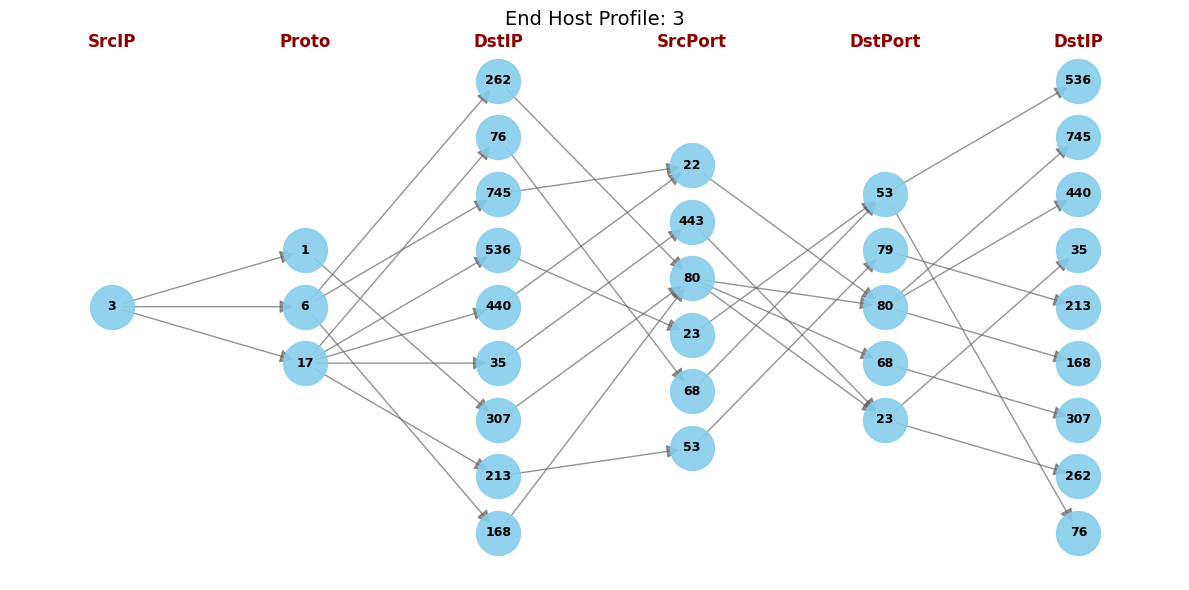

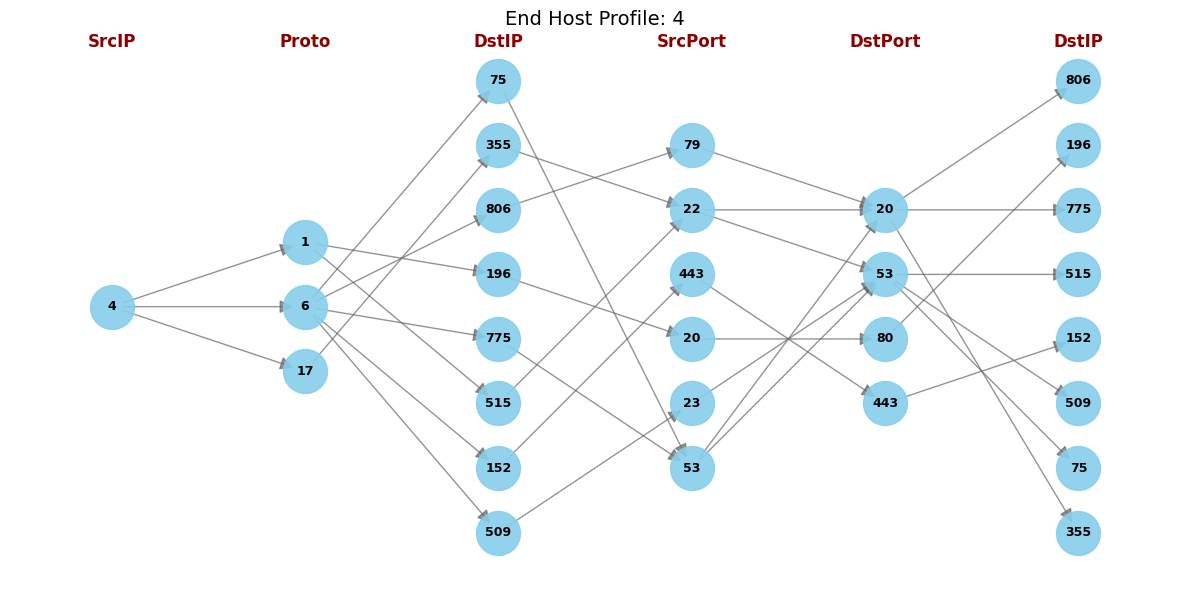

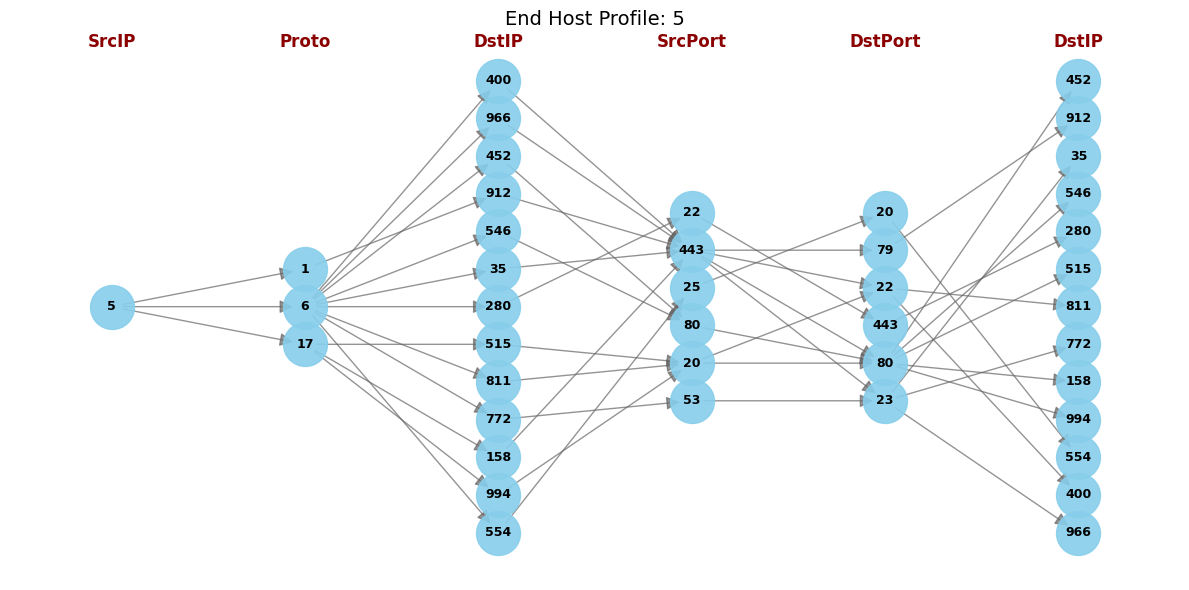

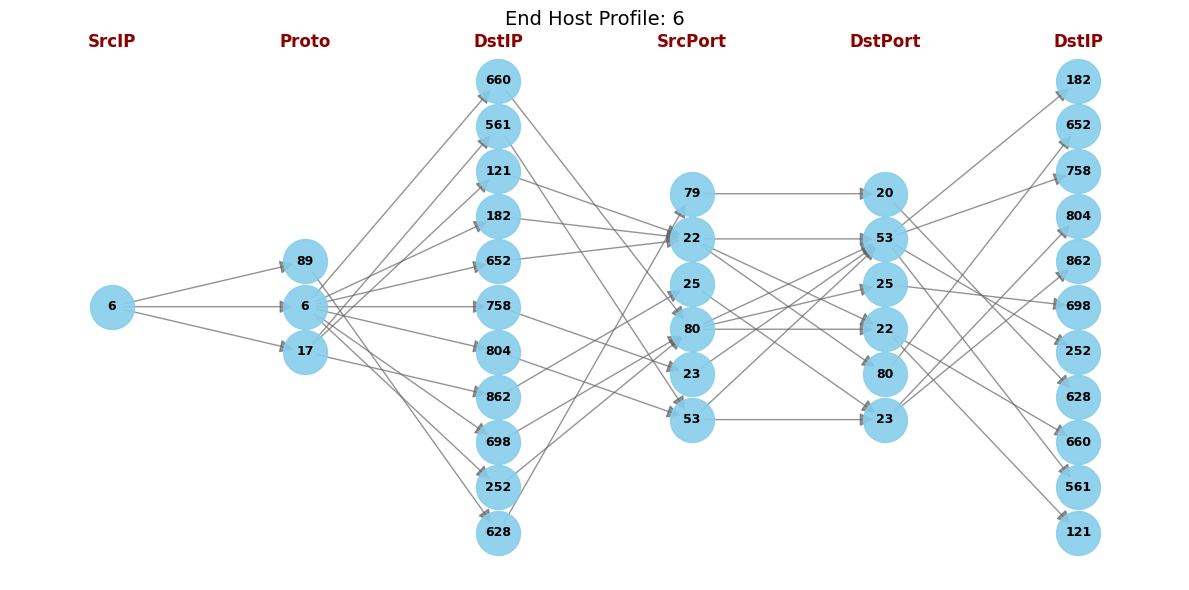

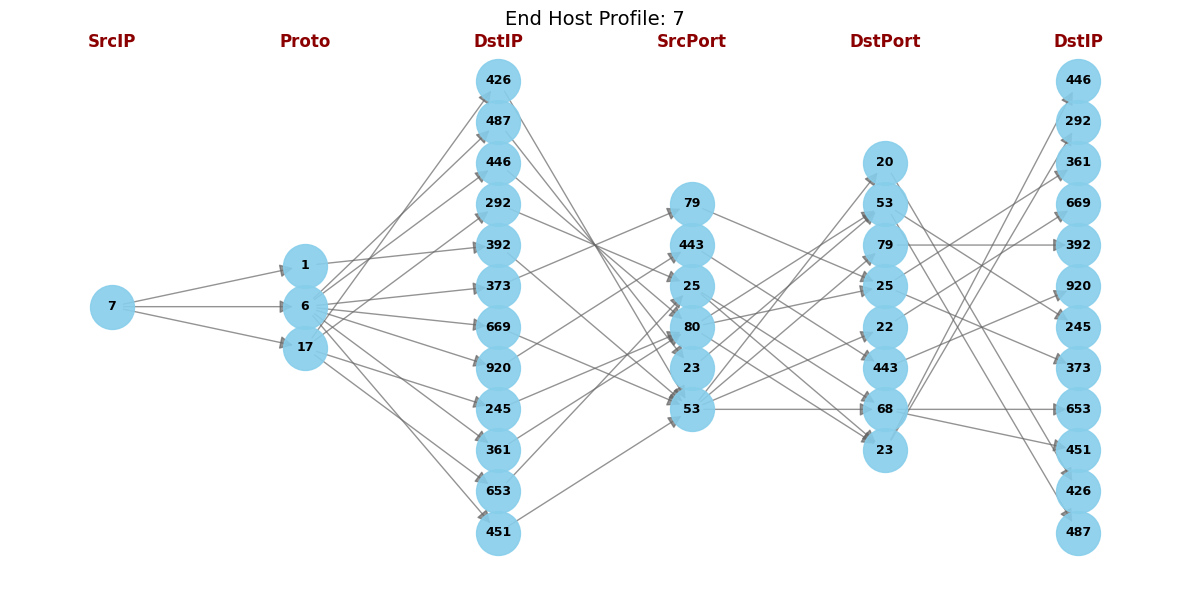

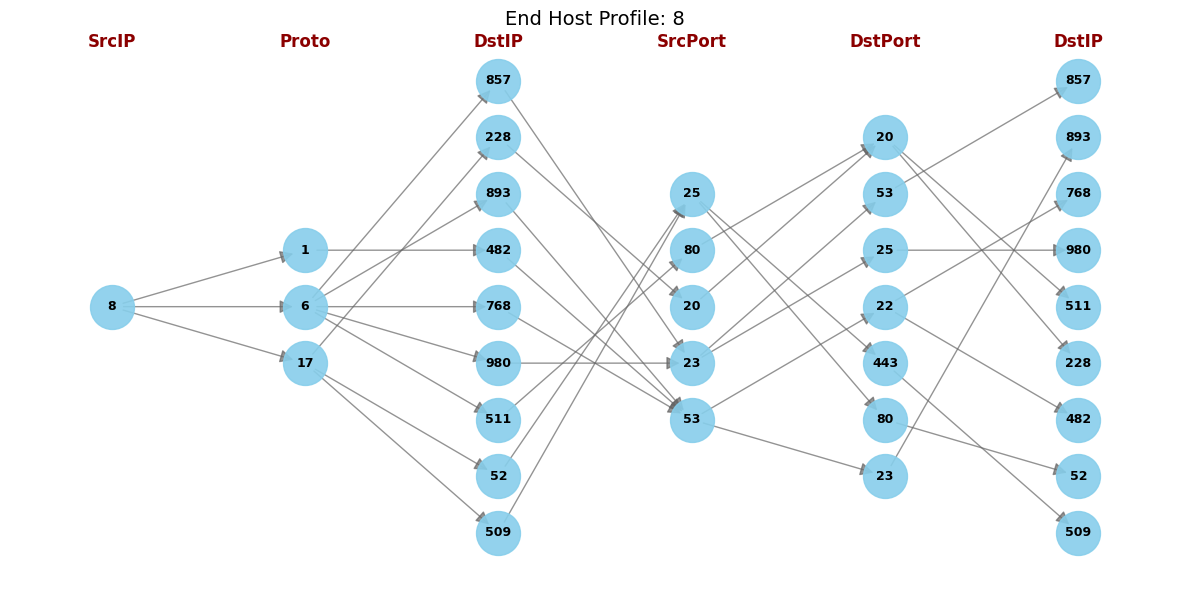

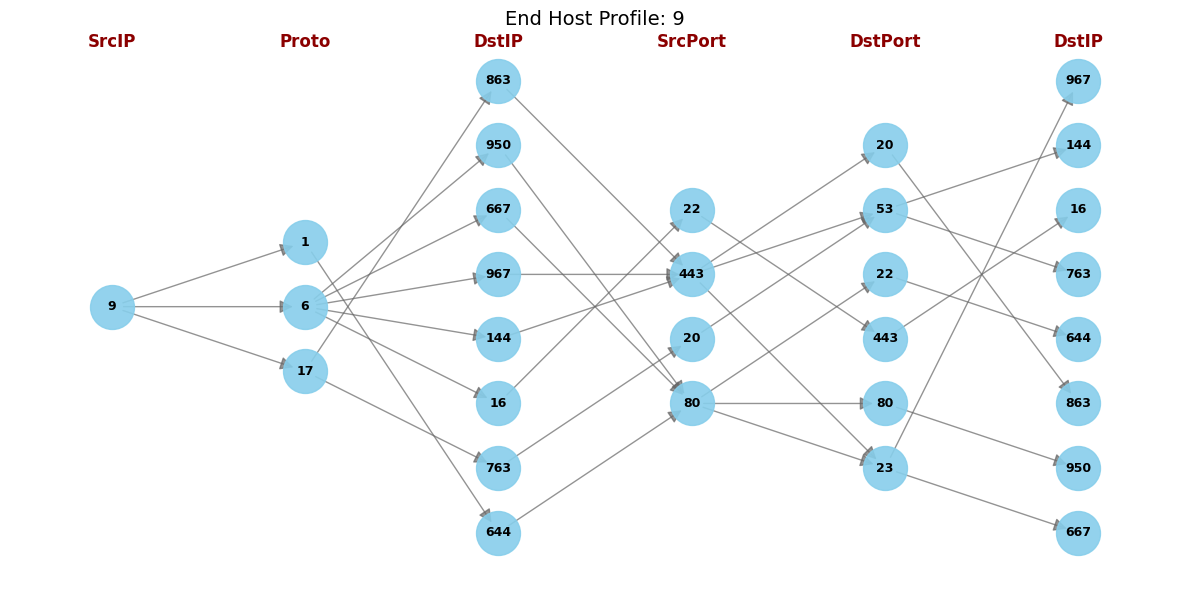

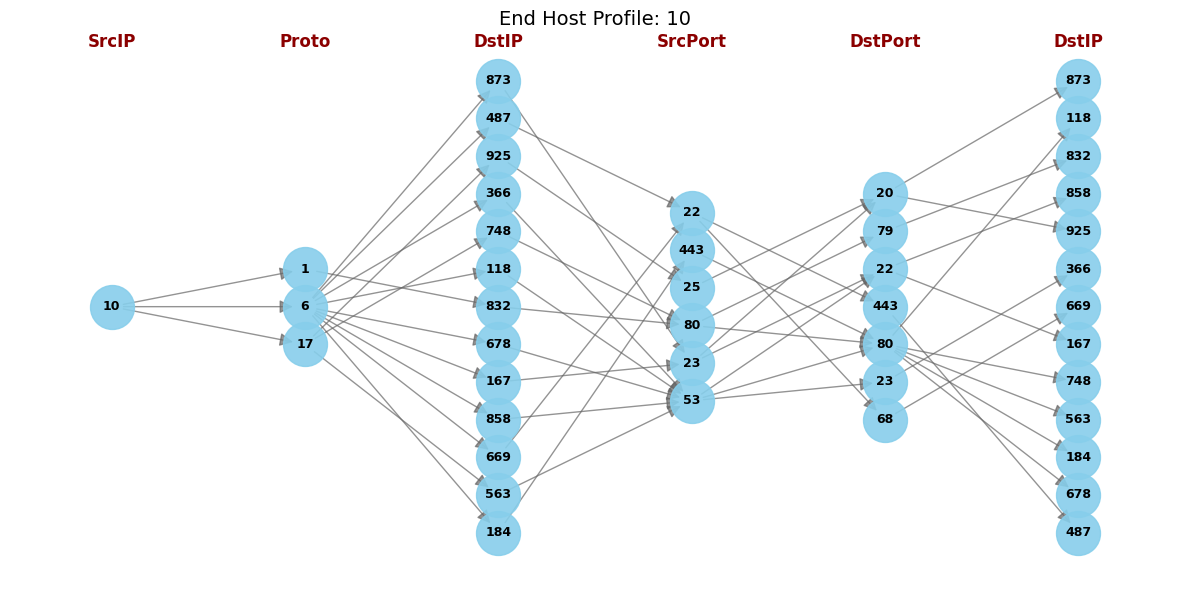

 (Total hosts: 1001)


In [4]:
import pandas as pd
import networkx as nx

# 1. Load the annotated trace
# The file 'annotated-trace.csv' contains the flows.
# Based on inspection, the columns are: srcIP, dstIP, proto, sPort, dPort, label
# We treat IPs as integers as specified.
column_names = ['srcIP', 'dstIP', 'proto', 'sPort', 'dPort', 'label']
df = pd.read_csv('annotated-trace.csv', header=None, names=column_names)

# 2. Function to build graphlets for all end hosts
def build_all_graphlets(df):
    """
    Constructs a dictionary of graphlets (NetworkX DiGraphs),
    keyed by the Source IP (End Host).
    """
    graphlets = {}

    # Group the dataframe by Source IP
    grouped = df.groupby('srcIP')

    for src_ip, group in grouped:
        G = nx.DiGraph()

        # Iterate over all flows for this specific host
        for _, row in group.iterrows():
            # Define the nodes for the graphlet columns:
            # Col 0: srcIP
            # Col 1: protocol (CSV col 'proto')
            # Col 2: dstIP (CSV col 'dstIP')
            # Col 3: sPort (CSV col 'sPort')
            # Col 4: dPort (CSV col 'dPort')
            # Col 5: dstIP (CSV col 'dstIP') - Repeated

            # We use tuples (column_index, value) to ensure nodes are distinct across columns
            nodes = [
                (0, row['srcIP']),
                (1, row['proto']),
                (2, row['dstIP']),
                (3, row['sPort']),
                (4, row['dPort']),
                (5, row['dstIP'])
            ]

            # Add edges sequentially: col 0 -> 1 -> 2 -> 3 -> 4 -> 5
            for i in range(len(nodes) - 1):
                u = nodes[i]
                v = nodes[i+1]
                G.add_edge(u, v)

                # Optional: Add subset attribute for visualization layouts
                G.nodes[u]['subset'] = i
                G.nodes[v]['subset'] = i + 1

        # Store the graphlet for this end host
        graphlets[src_ip] = G

    return graphlets

# 3. Execution
host_graphlets = build_all_graphlets(df)

print(f"Successfully built graphlets for {len(host_graphlets)} unique end hosts.")

def plot_all_graphlets(graphlets):
    count = 0
    total = len(graphlets)

    for src_ip, G in graphlets.items():
        # --- Safety Break for Notebooks ---
        # Plotting 1000+ graphs inline is not recommended.
        # Remove these lines to plot everything.
        if count >= 10:
            print(f" (Total hosts: {total})")
            break
        # ----------------------------------

        plt.figure(figsize=(12, 6))

        # Use multipartite layout based on the 'subset' attribute you assigned
        pos = nx.multipartite_layout(G, subset_key="subset")

        # Draw Nodes and Edges
        nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000, alpha=0.9)
        nx.draw_networkx_edges(G, pos, edge_color='#666666', arrowsize=20, alpha=0.7)

        # Clean Labels: The nodes are tuples like (0, '192.168...').
        # We only want to print the value '192.168...'.
        labels = {node: node[1] for node in G.nodes()}
        nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight="bold")

        # Add Column Headers for clarity
        column_headers = ["SrcIP", "Proto", "DstIP", "SrcPort", "DstPort", "DstIP"]
        # Determine Y height for headers
        y_max = max(p[1] for p in pos.values()) + 0.15

        for i, header in enumerate(column_headers):
            # Find the x-coordinate of the column 'i'
            try:
                # Get the x-coord of the first node found in this column
                x_coord = pos[next(n for n in G.nodes if n[0] == i)][0]
                plt.text(x_coord, y_max, header, ha='center', fontsize=12,
                         fontweight='bold', color='darkred')
            except StopIteration:
                pass # Handle empty columns if any

        plt.title(f"End Host Profile: {src_ip}", fontsize=14)
        plt.axis('off')
        plt.tight_layout()
        plt.show()

        count += 1

# Execute the plotting function
plot_all_graphlets(host_graphlets)

### 6 - Build a function to transform the graphlets into the high dimensional space of the random walk kernel (consider only walks of length 4)

In [5]:
import pandas as pd
import networkx as nx
import numpy as np
import time  #timing

# Start timing
start_qst6 = time.time()

# --- STEP 1: DATA LOADING ---
column_names = ['srcIP', 'dstIP', 'proto', 'sPort', 'dPort', 'label']
try:
    df = pd.read_csv('annotated-trace.csv', header=None, names=column_names)
except FileNotFoundError:
    print("WARNING: File not found. Using dummy data.")
    data = {'srcIP': [1]*5, 'dstIP': [10]*5, 'proto': [6]*5, 'sPort': [80]*5, 'dPort': [50, 51, 52, 53, 54], 'label': ['normal']*5}
    df = pd.DataFrame(data)

# --- STEP 2: BUILD GRAPHLETS ---
def build_all_graphlets(df):
    graphlets = {}
    grouped = df.groupby('srcIP')
    for src_ip, group in grouped:
        G = nx.DiGraph()
        for _, row in group.iterrows():
            nodes = [
                (0, row['srcIP']), (1, row['proto']), (2, row['dstIP']),
                (3, row['sPort']), (4, row['dPort']), (5, row['dstIP'])
            ]
            for i in range(len(nodes) - 1):
                G.add_edge(nodes[i], nodes[i+1])
        graphlets[src_ip] = G
    return graphlets

host_graphlets = build_all_graphlets(df)
print(f"Graphlets built: {len(host_graphlets)}")

# --- STEP 6: EXPLICIT MAPPING ---
def get_walks_of_length_k(G, k):
    walks = []
    def dfs(current_node, current_path):
        if len(current_path) == k + 1:
            walk_signature = "->".join([str(node[1]) for node in current_path])
            walks.append(walk_signature)
            return
        for neighbor in G.successors(current_node):
            dfs(neighbor, current_path + [neighbor])
    for node in G.nodes():
        dfs(node, [node])
    return walks

def transform_to_high_dimensional_space(graphlets, k=4):
    print(f"Mapping in progress...")
    all_hosts_walks = {}
    vocabulary = set()

    for src_ip, G in graphlets.items():
        walks = get_walks_of_length_k(G, k)
        all_hosts_walks[src_ip] = walks
        for w in walks:
            vocabulary.add(w)

    vocab_list = sorted(list(vocabulary))
    vocab_index = {walk: i for i, walk in enumerate(vocab_list)}
    n_features = len(vocab_list)
    n_samples = len(graphlets)

    X = np.zeros((n_samples, n_features), dtype=int)
    host_list = []

    for i, (src_ip, walks) in enumerate(all_hosts_walks.items()):
        host_list.append(src_ip)
        for w in walks:
            if w in vocab_index:
                X[i, vocab_index[w]] += 1

    return X, vocab_list, host_list

X, feature_names, ips = transform_to_high_dimensional_space(host_graphlets, k=4)

# Stop timing
time_qst6 = time.time() - start_qst6
print(f"\nTOTAL TIME (Mapping): {time_qst6:.4f} seconds")

# --- SMART VISUALIZATION ---
print("\n" + "="*60)
print(" FILTERED MATRIX (Only the most frequent Features)")
print("="*60)
col_sums = X.sum(axis=0)
top_indices = np.argsort(col_sums)[-15:][::-1]
top_features = [feature_names[i] for i in top_indices]
top_X = X[:, top_indices]
n_hosts_show = 10
df_view = pd.DataFrame(data=top_X[:n_hosts_show], index=ips[:n_hosts_show], columns=top_features)
df_view.index.name = "Host (SrcIP)"
print(df_view)

Graphlets built: 1001
Mapping in progress...

TOTAL TIME (Mapping): 0.8094 seconds

 FILTERED MATRIX (Only the most frequent Features)
              17->7->53->20->7  17->7->22->20->7  17->7->443->20->7  \
Host (SrcIP)                                                          
1                            0                 0                  0   
2                            0                 0                  0   
3                            0                 0                  0   
4                            0                 0                  0   
5                            0                 0                  0   
6                            0                 0                  0   
7                            0                 0                  0   
8                            0                 0                  0   
9                            0                 0                  0   
10                           0                 0                  0   

            

### 7 - Use a Support Vector Machine algorithm to build a model separating the normal from the malicious end hosts in the high dimensional space

In [6]:
import pandas as pd
import networkx as nx
import numpy as np
import time # timing
from scipy.sparse import dok_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
from sklearn.feature_extraction.text import TfidfTransformer

# Start timing
start_qst7 = time.time()

# --- 1. LOAD DATA ---
print("1. Loading Data...")
column_names = ['srcIP', 'dstIP', 'proto', 'sPort', 'dPort', 'label']
try:
    df = pd.read_csv('annotated-trace.csv', header=None, names=column_names)
except FileNotFoundError:
    print("Error: file annotated-trace.csv not found.")
    exit()

malicious_ips_set = set(df[df['label'] == 'anomaly']['srcIP'].unique())

# --- 2. BUILD GRAPHLETS ---
print("2. Building Graphlets...")
def build_graphlets(dataframe):
    graphlets = {}
    grouped = dataframe.groupby('srcIP')
    for src_ip, group in grouped:
        G = nx.DiGraph()
        for _, row in group.iterrows():
            nodes = [
                (0, row['srcIP']), (1, row['proto']), (2, row['dstIP']),
                (3, row['sPort']), (4, row['dPort']), (5, row['dstIP'])
            ]
            for i in range(len(nodes) - 1):
                G.add_edge(nodes[i], nodes[i+1])
        graphlets[src_ip] = G
    return graphlets

host_graphlets = build_graphlets(df)

# --- 3. EXTRACT WALKS (k=4) ---
print("3. Extracting Random Walks (k=4)...")
def get_walks(G, k=4):
    walks = []
    def dfs(node, path):
        if len(path) == k + 1:
            walks.append("->".join([str(n[1]) for n in path]))
            return
        for neighbor in G.successors(node):
            dfs(neighbor, path + [neighbor])
    for node in G.nodes():
        dfs(node, [node])
    return walks

host_walks_map = {}
all_walks = set()

for ip, G in host_graphlets.items():
    w_list = get_walks(G, k=4)
    host_walks_map[ip] = w_list
    all_walks.update(w_list)

vocab = sorted(list(all_walks))
vocab_idx = {w: i for i, w in enumerate(vocab)}
n_samples = len(host_graphlets)
n_features = len(vocab)

X_raw = dok_matrix((n_samples, n_features), dtype=int)
y = []

for i, (ip, w_list) in enumerate(host_walks_map.items()):
    y.append(1 if ip in malicious_ips_set else 0)
    for w in w_list:
        if w in vocab_idx:
            X_raw[i, vocab_idx[w]] += 1

X_raw = X_raw.tocsr()
y = np.array(y)

# --- 4. TF-IDF NORMALIZATION ---
print("4. Applying TF-IDF...")
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_raw)

# --- 5. TRAIN SVM ---
print("5. Training SVM (RBF Kernel)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y
)

svm_model = SVC(kernel='rbf', class_weight='balanced', C=1000, gamma='scale', probability=True)
svm_model.fit(X_train, y_train)

# --- 6. AUTOMATIC THRESHOLD TUNING ---
print("6. Optimizing Decision Threshold...")
y_proba = svm_model.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
y_pred_optimized = (y_proba >= best_threshold).astype(int)

# Stop timing
time_qst7 = time.time() - start_qst7
print(f"\nTOTAL (SVM Modeling): {time_qst7:.4f} seconds")

# --- 7. FINAL RESULTS ---
print("\n" + "="*50)
print("        FINAL RESULTS (Optimized)        ")
print("="*50)
cm = confusion_matrix(y_test, y_pred_optimized)
print(f" [ TN {cm[0][0]} | FP {cm[0][1]} ]\n [ FN {cm[1][0]} | TP {cm[1][1]} ]")
print(classification_report(y_test, y_pred_optimized, target_names=['Normal', 'Malicious']))

1. Loading Data...
2. Building Graphlets...
3. Extracting Random Walks (k=4)...
4. Applying TF-IDF...
5. Training SVM (RBF Kernel)...
6. Optimizing Decision Threshold...

TOTAL (SVM Modeling): 2.5770 seconds

        FINAL RESULTS (Optimized)        
 [ TN 188 | FP 1 ]
 [ FN 9 | TP 3 ]
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97       189
   Malicious       0.75      0.25      0.38        12

    accuracy                           0.95       201
   macro avg       0.85      0.62      0.67       201
weighted avg       0.94      0.95      0.94       201



Step 7 involved training a Support Vector Machine (SVM) to classify end hosts as either "normal" or "malicious" based on their communication patterns. We leveraged the explicit feature space constructed in the previous step, where each host was represented by a high-dimensional vector of length-4 random walks extracted from their corresponding graphlets.

To address the class imbalance—where malicious hosts were a small minority compared to normal ones—we applied Term Frequency-Inverse Document Frequency (TF-IDF) normalization. This technique weighted the features, reducing the influence of common traffic patterns while emphasizing unique sequences more indicative of anomalous behavior. We then trained an SVM using a Radial Basis Function (RBF) kernel and balanced class weights to further penalize the misclassification of the minority class.

Crucially, rather than relying on the default decision boundary, we optimized the classification threshold by analyzing the Precision-Recall curve. By selecting a threshold that maximized the F1-score, we calibrated the model to detect subtle signs of compromise. On the test set, the model achieved a precision of 75% with only a single false positive, ensuring that flagged anomalies were likely genuine. However, the recall was 25%, indicating that while the model is trustworthy when it raises an alert, it is conservative and missed a portion of the subtler attack patterns.

### 8. Use now the kernel trick to avoid having to map your graphlet in the high dimensional space. Compare the computation time.

In [8]:
import time
import math
import numpy as np
import networkx as nx
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

# ----------------------------
# 1) Walk extraction (same idea as Step 7)
# ----------------------------
def get_walks(G, k=4):
    walks = []
    def dfs(node, path):
        if len(path) == k + 1:
            # Use the same "value-only" representation you used in Step 7
            walks.append("->".join([str(n[1]) for n in path]))
            return
        for neighbor in G.successors(node):
            dfs(neighbor, path + [neighbor])

    for node in G.nodes():
        dfs(node, [node])
    return walks

def build_walk_counters(host_graphlets, k=4):
    host_list = list(host_graphlets.keys())  # fixed ordering used everywhere
    counters = []
    for ip in host_list:
        walks = get_walks(host_graphlets[ip], k=k)
        counters.append(Counter(walks))
    return host_list, counters

# ----------------------------
# 2) Kernel computation (bag-of-walks dot product)
#    Optional: cosine normalization so big graphs don't dominate
# ----------------------------
def dot_counter(a: Counter, b: Counter) -> float:
    # iterate on the smaller counter for speed
    if len(a) > len(b):
        a, b = b, a
    return sum(v * b.get(k, 0) for k, v in a.items())

def compute_kernel_matrix(counters, normalize=True):
    n = len(counters)
    K = np.zeros((n, n), dtype=float)

    # self-similarities for normalization
    diag = np.zeros(n, dtype=float)
    for i in range(n):
        diag[i] = dot_counter(counters[i], counters[i])

    for i in range(n):
        K[i, i] = diag[i]
        for j in range(i + 1, n):
            kij = dot_counter(counters[i], counters[j])
            K[i, j] = K[j, i] = kij

    if normalize:
        eps = 1e-12
        for i in range(n):
            for j in range(n):
                denom = math.sqrt((diag[i] + eps) * (diag[j] + eps))
                K[i, j] = K[i, j] / denom

    return K

# ----------------------------
# 3) Full Step 8 pipeline
# ----------------------------
# Assumes you already have:
# - host_graphlets (dict: ip -> DiGraph)
# - y aligned to hosts (we will rebuild y to guarantee alignment)

start_q8 = time.time()

# Build counters (implicit feature representation)
host_list, walk_counters = build_walk_counters(host_graphlets, k=4)

# IMPORTANT: rebuild y aligned with host_list to avoid label/order bugs
# You must have malicious_ips_set from Step 7 (or rebuild it similarly)
y_aligned = np.array([1 if ip in malicious_ips_set else 0 for ip in host_list])

# Compute full kernel matrix
t0 = time.time()
K = compute_kernel_matrix(walk_counters, normalize=True)
kernel_time = time.time() - t0
print(f"Kernel matrix computed in: {kernel_time:.4f} s  |  shape={K.shape}")

# Train/test split on indices, then slice K correctly
idx = np.arange(len(host_list))
idx_train, idx_test, y_train, y_test = train_test_split(
    idx, y_aligned, test_size=0.2, random_state=42, stratify=y_aligned
)

K_train = K[np.ix_(idx_train, idx_train)]
K_test  = K[np.ix_(idx_test, idx_train)]  # test rows vs train columns

# Train SVM with precomputed kernel
svm_kernel = SVC(kernel='precomputed', class_weight='balanced', C=1.0, probability=True)
svm_kernel.fit(K_train, y_train)

# Predict + optional threshold tuning (like your Step 7)
y_proba = svm_kernel.predict_proba(K_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-12)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5

y_pred = (y_proba >= best_threshold).astype(int)

total_time_q8 = time.time() - start_q8
print(f"TOTAL (Kernel Trick Step 8): {total_time_q8:.4f} seconds")

# Report
cm = confusion_matrix(y_test, y_pred)
print("\n" + "="*50)
print("        STEP 8 RESULTS (Kernel Trick)      ")
print("="*50)
print(f" [ TN {cm[0][0]} | FP {cm[0][1]} ]\n [ FN {cm[1][0]} | TP {cm[1][1]} ]")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Malicious']))
print(f"Best threshold = {best_threshold:.4f}")


Kernel matrix computed in: 2.7083 s  |  shape=(1001, 1001)
TOTAL (Kernel Trick Step 8): 2.8762 seconds

        STEP 8 RESULTS (Kernel Trick)      
 [ TN 188 | FP 1 ]
 [ FN 9 | TP 3 ]
              precision    recall  f1-score   support

      Normal       0.95      0.99      0.97       189
   Malicious       0.75      0.25      0.38        12

    accuracy                           0.95       201
   macro avg       0.85      0.62      0.67       201
weighted avg       0.94      0.95      0.94       201

Best threshold = 0.1209


the Kernel Trick is more efficient than the Explicit Mapping pipeline because it computes similarity directly between graphlets using a Bag-of-Walks kernel, avoiding the costly overhead of building a massive global feature vocabulary.